# Surrogate Gradient Tutorial

Welcome! This tutorial demonstrates the full power of Spyx: fully Just-In-Time compiled training to achieve incredible throughput! This notebook will demonstrate how you can train a spiking neural network on the Spiking Heidelberg Digits dataset in under a minute on any GPU!

In [ ]:
!pip install tonic
!pip install nir
!pip install spyx

In [2]:
import spyx
import spyx.nn as snn

# JAX imports
import os
import jax
from jax import numpy as jnp
import jmp
import numpy as np

from jax_tqdm import scan_tqdm
from tqdm import tqdm

# implement our SNN in DeepMind's Haiku
import haiku as hk

# for surrogate loss training.
import optax

# rendering tools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Set Mixed Precision Policy

Since Spyx is built on top of Haiku, we can leverage the JAX Mixed Precision (JMP) library to automatically cast the numerical precision of different modules in our SNN. This allows us to have very granular control over the precision of different layers in the model (say, computing the linear layers in half precision but maintaining full precision for neuron state); the motivation for doing so is that NVIDIA's top-end GPU accelerators as well as Google's TPU use reduced numerical precision in order to achieve higher computational throughput, meaning our model can run faster with minimal losses in accuracy! For other GPUs more common in desktops, using half precision only yields memory savings, whereas on A100/H100/TPU using mixed precision also results in a higher number of FLOPS.

In [3]:
policy = jmp.get_policy('half')


hk.mixed_precision.set_policy(hk.Linear, policy)
hk.mixed_precision.set_policy(snn.LIF, policy)
hk.mixed_precision.set_policy(snn.LI, policy)

## Data Loading

For the template, the Spiking Heidelberg Dataset is used. Feel free to replace this section with your own dataloading pipeline, just be sure once you've loaded and processed your whole dataset into RAM as a single numpy array and call np.packbits(data, axis=\<time axis\>) to compress the data prior to converting it to a jax.numpy array.

In [4]:
shd_dl = spyx.data.SHD_loader(256,128,128)

In [5]:
# JAX has deterministic pseudorandom number generation
key = jax.random.PRNGKey(0)
x, y = shd_dl.train_epoch(key)

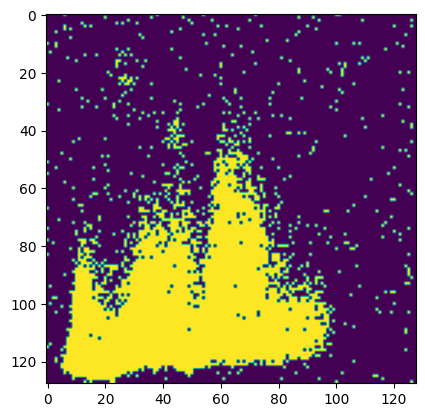

In [6]:
plt.imshow(np.unpackbits(x[0][69], axis=0).T)
plt.show()

In [7]:
y.shape

(25, 256)

## SNN

Here we define a simple feed-forward SNN using Haiku's RNN features, incorporating our
LIF neuron models where activation functions would usually go. Haiku manages all of the state for us, so when we transform the function and get an apply() function we just need to pass the params!

Since spiking neurons have a discrete all-or-nothing activation, we'll approximate the gradient using a triangular surrogate gradient.


In [8]:
def shd_snn(x):

    # We can use batch apply to apply the first linear layer across all of the input data
    x = hk.BatchApply(hk.Linear(64, with_bias=False))(x)

    # Haiku has the ability to stack multiple layers/recurrent modules as one entity
    core = hk.DeepRNN([
        snn.LIF((64,), activation=spyx.axn.Axon(spyx.axn.triangular())), #LIF neuron layer with triangular activation
        hk.Linear(64, with_bias=False),
        snn.LIF((64,), activation=spyx.axn.Axon(spyx.axn.triangular())),
        hk.Linear(20, with_bias=False),
        snn.LI((20,)) # Non-spiking final layer
    ])

    # This takes our SNN core and computes it across the input data.
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=32) # unroll our model.

    return spikes, V

In [9]:
# Create a random key
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
SNN = hk.without_apply_rng(hk.transform(shd_snn))
params = SNN.init(rng=key, x=x[0])

## Gradient Descent

In [10]:
def gd(SNN, params, dl, epochs=300, schedule=3e-4):

    # We use optax for our optimizer.
    opt = optax.lion(learning_rate=schedule)

    # create and initialize the optimizer
    opt_state = opt.init(params)
    grad_params = params

    # define and compile our eval function that computes the loss for our SNN
    @jax.jit
    def net_eval(weights, events, targets):
        readout = SNN.apply(weights, events)
        traces, V_f = readout
        return spyx.fn.integral_crossentropy(traces, targets)

    # Use JAX to create a function that calculates the loss and the gradient!
    surrogate_grad = jax.value_and_grad(net_eval)

    rng = jax.random.PRNGKey(0)

    # compile the meat of our training loop for speed
    @jax.jit
    def train_step(state, data):
        # unpack the parameters and optimizer state
        grad_params, opt_state = state
        # unpack the data into x, y
        events, targets = data
        events = jnp.unpackbits(events, axis=1) # decompress temporal axis
        # compute loss and gradient
        loss, grads = surrogate_grad(grad_params, events, targets)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state]
        return new_state, loss

    # For validation epochs, do the same as before but compute the
    # accuracy, predictions and losses (no gradients needed)
    @jax.jit
    def eval_step(grad_params, data):
        # unpack our data
        events, targets = data
        # decompress information along temporal axis
        events = jnp.unpackbits(events, axis=1)
        # apply the network to the data
        readout = SNN.apply(grad_params, events)
        # unpack the final layer outputs and end state of each SNN layer
        traces, V_f = readout
        # compute accuracy, predictions, and loss
        acc, pred = spyx.fn.integral_accuracy(traces, targets)
        loss = spyx.fn.integral_crossentropy(traces, targets)
        # we return the parameters here because of how jax.scan is structured.
        return grad_params, jnp.array([acc, loss])


    val_data = dl.val_epoch()

    # Here's the start of our training loop!
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state

        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        train_data = dl.train_epoch(shuffle_rng)

        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# our function which computes and updates gradients for one batch
            [curr_params, curr_opt_state], # initialize with parameters and optimizer state of current epoch
            train_data,# pass the newly shuffled training data
            train_data.obs.shape[0]# this corresponds to the number of training batches
        )

        new_params, _ = end_state

        # val epoch
        _, val_metrics = jax.lax.scan(
            eval_step,# func
            new_params,# init
            val_data,# xs
            val_data.obs.shape[0]# len
        )


        return end_state, jnp.concatenate([jnp.expand_dims(jnp.mean(train_loss),0), jnp.mean(val_metrics, axis=0)])
    # end epoch

    # epoch loop
    final_state, metrics = jax.lax.scan(
        epoch,
        [grad_params, opt_state], # metric arrays
        jnp.arange(epochs), #
        epochs # len of loop
    )

    final_params, final_optimizer_state = final_state


    # return our final, optimized network.
    return final_params, metrics

In [11]:
def test_gd(SNN, params, dl):

    @jax.jit
    def test_step(params, data):
        events, targets = data
        events = jnp.unpackbits(events, axis=1)
        readout = SNN.apply(params, events)
        traces, V_f = readout
        acc, pred = spyx.fn.integral_accuracy(traces, targets)
        loss = spyx.fn.integral_crossentropy(traces, targets)
        return params, [acc, loss, pred, targets]

    test_data = dl.test_epoch()

    _, test_metrics = jax.lax.scan(
            test_step,# func
            params,# init
            test_data,# xs
            test_data.obs.shape[0]# len
    )

    acc = jnp.mean(test_metrics[0])
    loss = jnp.mean(test_metrics[1])
    preds = jnp.array(test_metrics[2]).flatten()
    tgts = jnp.array(test_metrics[3]).flatten()
    return acc, loss, preds, tgts

## Training Time

In [12]:
grad_params, metrics = gd(SNN, params, shd_dl, epochs=300) # this takes a minute or two to compile on Colab because of weak CPU compute.

  0%|          | 0/300 [00:00<?, ?it/s]

In [13]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*metrics[-1]))

Performance: train_loss=1.6130576133728027, val_acc=0.9016927480697632, val_loss=1.7374032735824585


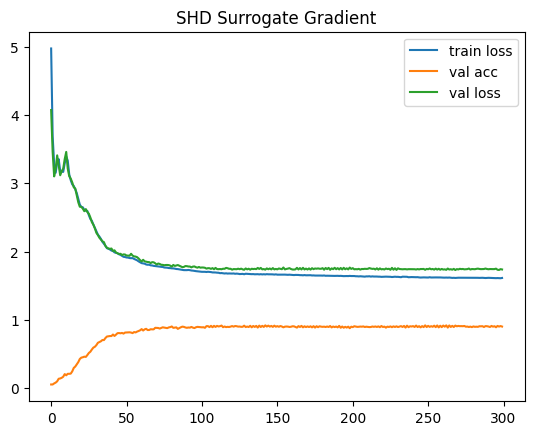

In [14]:
plt.plot(metrics, label=["train loss", "val acc", "val loss"])
plt.title("SHD Surrogate Gradient")
plt.legend()
plt.show()

## Evaluation Time

Now we'll run the network on the test set and see what happens:

In [15]:
acc, loss, preds, tgts = test_gd(SNN, grad_params, shd_dl)
print("Accuracy:", acc, "Loss:", loss)

Accuracy: 0.7548828 Loss: 1.9744271


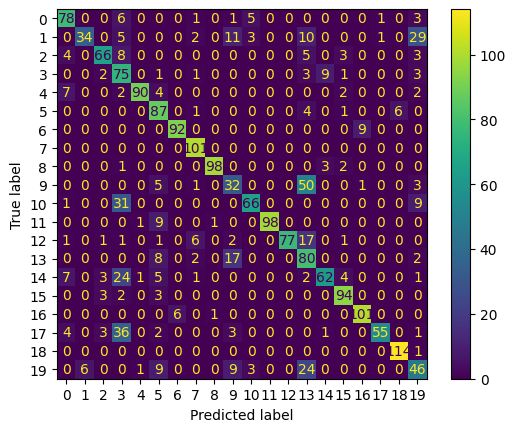

In [16]:
cm = confusion_matrix(tgts, preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()